In [1]:
from nlp_functions import *
sess = tf.Session()

Using TensorFlow backend.


In [2]:
plt.style.use('seaborn')

In [3]:
# Importing our data
sentiment140 = read_sentiment_file(DATA_DIRECTORY, 'sentiment140_train.csv')

In [4]:
# Sampling 50% the data
sentiment140 = sentiment140.sample(frac=0.5, random_state=7)

In [5]:
# Separating into characteristics and labels
X = sentiment140['text']
y = sentiment140['polarity']

In [6]:
# Cleaning the texts
X = clean_data(X)

In [7]:
# Mapping for easier classificacion
y = y.map({0: int(0), 4: int(1)})

In [8]:
# Split the data to train and test, then train and val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7)

In [9]:
# Tokenizing the data
tk, word_index, vocab_size = tokenize(X_train, X_val, X_test)

In [10]:
# Each sentence is converted into an array of integers
X_train = tk.texts_to_sequences(X_train)
X_val = tk.texts_to_sequences(X_val)
X_test = tk.texts_to_sequences(X_test)

In [11]:
# Calculation of maximum length to adjust the padding
maxlen = longest_sentence(X_train, X_val, X_test)

In [12]:
# Padding is applied to get the same dimension
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [13]:
# Creating the embedding matrix based on dimension and vocabulary of our texts
EMBEDDING_DIM = 300
embedding_matrix = create_embedding_matrix(vocab_size, EMBEDDING_DIM, word_index)

In [14]:
# Check the ratio of words in our texts are included in the embedding_matrix
print('Using GloVe (Wiki database)')
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

Using GloVe (Wiki database)


0.47543481020693157

In [15]:
# Architecture for CNN + GloVe model
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=False))
model.add(Conv1D(
    filters=250,
    kernel_size=3,
    activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           40172700  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 250)           225250    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (De

In [16]:
# Training and validation for CNN + GloVe model
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True)
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping])


Train on 512000 samples, validate on 128000 samples
Epoch 1/100
512000/512000 [==============================] - 43s 84us/step - loss: 0.5468 - accuracy: 0.7191 - precision: 0.7236 - recall: 0.7085 - val_loss: 0.4962 - val_accuracy: 0.7570 - val_precision: 0.7201 - val_recall: 0.8409
Epoch 2/100
512000/512000 [==============================] - 42s 82us/step - loss: 0.4798 - accuracy: 0.7714 - precision: 0.7781 - recall: 0.7590 - val_loss: 0.4589 - val_accuracy: 0.7822 - val_precision: 0.7945 - val_recall: 0.7616
Epoch 3/100
512000/512000 [==============================] - 42s 83us/step - loss: 0.4580 - accuracy: 0.7854 - precision: 0.7922 - recall: 0.7736 - val_loss: 0.4480 - val_accuracy: 0.7899 - val_precision: 0.7936 - val_recall: 0.7837
Epoch 4/100
512000/512000 [==============================] - 42s 83us/step - loss: 0.4429 - accuracy: 0.7947 - precision: 0.8022 - recall: 0.7820 - val_loss: 0.4436 - val_accuracy: 0.7913 - val_precision: 0.8247 - val_recall: 0.7400
Epoch 5/100
512

In [17]:
metrics = pd.DataFrame(history.history)
metrics

,val_loss,val_accuracy,val_precision,val_recall,loss,accuracy,precision,recall
0,0.496181,0.756992,0.720148,0.840945,0.546771,0.719055,0.723618,0.708507
1,0.458915,0.782234,0.794480,0.761644,0.479766,0.771369,0.778100,0.759026
2,0.448008,0.789875,0.793625,0.783684,0.458002,0.785438,0.792224,0.773606
3,0.443645,0.791281,0.824705,0.739996,0.442904,0.794650,0.802193,0.781964
4,0.435581,0.796195,0.796214,0.796351,0.431278,0.801494,0.808613,0.789764
5,0.432307,0.797547,0.793626,0.804411,0.420398,0.807332,0.814332,0.796009
6,0.430366,0.799484,0.812111,0.779435,0.411151,0.812576,0.819759,0.801163
7,0.427103,0.801641,0.809651,0.788885,0.402196,0.816641,0.823447,0.805942
8,0.427275,0.801000,0.801323,0.800647,0.394726,0.821219,0.828132,0.810514
9,0.427257,0.801539,0.807207,0.792493,0.386679,0.825338,0.832319,0.814668


In [18]:
print(f'Best training loss: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,4]}')
print(f'Best training accuracy: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,5]}')
print(f'Best training precision: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,6]}')
print(f'Best training recall: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,7]}')
print('---------------------------------------------')
print(f'Best validation loss: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,0]}')
print(f'Best validation accuracy: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,1]}')
print(f'Best validation precision: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,2]}')
print(f'Best validation recall: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,3]}')

Best training loss: 0.4021962930392474
Best training accuracy: 0.8166406154632568
Best training precision: 0.8234469890594482
Best training recall: 0.8059421181678772
---------------------------------------------
Best validation loss: 0.42710292145609857
Best validation accuracy: 0.8016406297683716
Best validation precision: 0.8096505403518677
Best validation recall: 0.7888850569725037


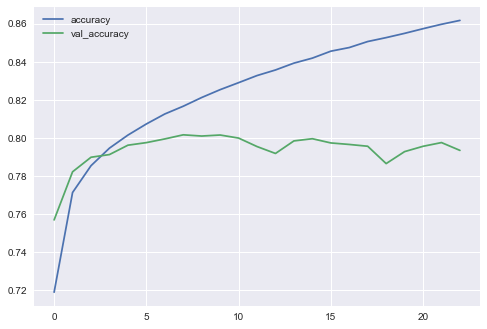

In [19]:
metrics[['accuracy','val_accuracy']].plot()
plt.savefig('../figures/cnn_glove300_50_acc.jpg', dpi=300)

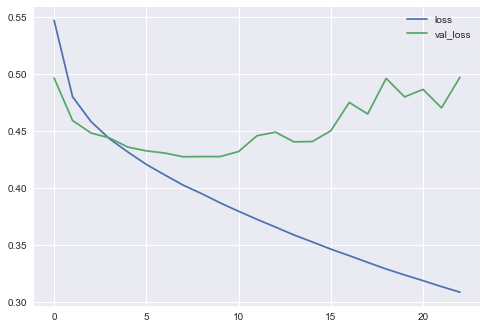

In [20]:
metrics[['loss','val_loss']].plot()
plt.savefig('../figures/cnn_glove300_50_loss.jpg', dpi=300)

In [21]:
# Evaluation on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)

160000/160000 [==============================] - 7s 45us/step


In [22]:
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test precision: {test_precision}')
print(f'Test recall: {test_recall}')

Test loss: 0.43039910138845444
Test accuracy: 0.8002812266349792
Test precision: 0.8067593574523926
Test recall: 0.787129282951355


In [23]:
model.save('../models/cnn_glove300_50.h5')